# [SOLUTION] Exercise 9: Design the Model Evaluation Strategy for a Classification Task

Metrics like precision, recall, and F1 score reveal different aspects of model performance, but how do you actually choose which metric matters most? And when two models have different precision-recall tradeoffs, how do you decide which is better?

> **Overview**: Move from computing metrics to designing evaluation strategies. You'll visualize performance across all possible thresholds using Precision-Recall and ROC curves, compare what each curve reveals about your model, and propose a deployment strategy that balances business constraints with model capabilities.
> 
> **Scenario**: Your fraud detection model catches 80% of fraud but only 34% of its fraud predictions are correct. Management needs a clear plan: which evaluation metric should guide model selection, and what decision threshold should the team use in deployment? Your task is to analyze the full precision-recall tradeoff space and recommend an evaluation strategy that balances fraud detection rate with customer trust.
> 
> **Goal**: Visualize model performance across thresholds, interpret Precision-Recall and ROC curves, and make strategic evaluation decisions based on business context.
> 
> **Tools**: Python, PyTorch, NumPy, scikit-learn, Matplotlib
> 
> **Estimated Time**: 20-25 minutes

## Step 1: Setup

Let's start by importing our libraries and setting up our environment.

In [1]:
# Import core libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Create output directory
output_dir = 'assets/_SOLUTION-exercise9'
os.makedirs(output_dir, exist_ok=True)

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("Setup complete!\n")

Using device: cuda
Setup complete!



## Step 2: Load data and pre-trained model

> Note: This step mirrors the exact same dataset, dataset processing, and model loading as for [demo 9](/cd1818-intro-to-deep-learning/9-evaluation/demo9-measuring-model-performance-beyond-accuracy.ipynb).

We'll work with the [David-Egea/Creditcard-fraud-detection](https://huggingface.co/datasets/David-Egea/Creditcard-fraud-detection) dataset from Hugging Face, which contains credit card transactions with severe class imbalance—perfect for demonstrating why evaluation strategy matters.

For **preprocessing**, we'll:
1. Load the dataset and subset to 50,000 transactions
2. Split features (V1-V28, Time, Amount) from labels (Class)
3. Create train/test split (70/30) with stratification
4. Normalize features for neural network training
5. Convert to PyTorch tensors

Then we'll load a **pre-trained model** for fraud detection. This is a simple feedforward neural network (2 hidden layers with 64 and 32 neurons) trained using BCEWithLogitsLoss with class weighting to handle the imbalance.

**IMPORTANT: Feel free to skip this section to focus on the evaluation strategy**. Just know that we end up with ~15,000 test transactions where only ~0.17% are fraudulent, and a pre-trained model that achieved low training loss. Your task is to evaluate this model properly and design a deployment strategy.

In [2]:
# Load and preprocess data

# 1. Load dataset
print("Loading credit card fraud dataset...")
dataset = load_dataset('David-Egea/Creditcard-fraud-detection', split='train')
df = dataset.to_pandas()
df = df.sample(n=50000, random_state=42).reset_index(drop=True)

# 2. Prepare features and labels
X = df.drop('Class', axis=1).values
y = df['Class'].values

# 3. Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 4. Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Convert to PyTorch tensors
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test)

print(f"✓ Data loaded: {len(X_test)} test samples")
print(f"✓ Test fraud rate: {(y_test.sum()/len(y_test))*100:.3f}%\n")

Loading credit card fraud dataset...
✓ Data loaded: 15000 test samples
✓ Test fraud rate: 0.167%



> **Why stratified splitting matters for imbalanced data**: With only 0.167% fraud (25 cases out of 15,000 test samples), random splitting could accidentally put most fraud cases in training or all in testing, making proper evaluation impossible. The `stratify=y` parameter ensures both splits maintain the same fraud percentage, giving us a representative test set. This is critical when the positive class is rare—without stratification, you might evaluate on a test set with zero fraud cases!

In [3]:
# Define and load the pre-trained model
class FraudDetector(nn.Module):
    def __init__(self, input_size=30):
        super(FraudDetector, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load pre-trained weights
model = FraudDetector(input_size=30)
model_path = 'assets/demo9/fraud_detector.pth'
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

print("✓ Pre-trained model loaded successfully")

✓ Pre-trained model loaded successfully


> **What makes this model "pre-trained"?** This model has already completed 200 epochs of training on the fraud detection dataset using BCEWithLogitsLoss (binary cross-entropy with logits) and the Adam optimizer. The training process adjusted the model's weights to minimize loss, and it achieved strong performance on the training set. 
> 
> But training performance doesn't guarantee the model is ready for deployment; that's what proper evaluation on held-out test data reveals.

## Step 3: Get predictions from the model

Now let's generate predictions on our test set. The model outputs raw logits (unbounded values), which you'll convert to probabilities using the sigmoid function. You'll also create binary predictions using the default 0.5 threshold as our baseline.

> <details><summary><strong>Why we need both predictions and probabilities</strong></summary>
> The model outputs raw probabilities (0.0 to 1.0) that estimate fraud likelihood. 
> 
>   - The *`predictions`* variable applies a default 0.5 threshold to create binary decisions. But here's the key insight: that 0.5 threshold is arbitrary! 
>   - To design the best evaluation strategy, we need the raw *`probabilities`* so we can explore what happens at 0.3, 0.5, 0.7, or any other threshold.
> 
> **Keep both:** you'll use probabilities to generate curves and predictions as your baseline comparison.
</details>


In [4]:
# Get predictions from the model
with torch.no_grad():
    logits = model(X_test_tensor.to(device)).squeeze()
    probabilities = torch.sigmoid(logits).cpu()
    predictions = (probabilities >= 0.5).float()

print("✓ Model predictions obtained")
print(f"  Predicted fraud cases: {predictions.sum().item():.0f}")
print(f"  Actual fraud cases: {y_test_tensor.sum().item():.0f}\n")

✓ Model predictions obtained
  Predicted fraud cases: 59
  Actual fraud cases: 25



> **First look at model behavior**: The model predicts 59 fraud cases when only 25 actually exist. This means we're already seeing the precision-recall tradeoff in action: the model is being aggressive (catching fraud) at the cost of false alarms. 
> 
> _Is 59 predictions for 25 actual cases good or bad?_ That depends on how many of those 59 are correct (precision) and how many of the 25 real fraud cases we caught (recall). You'll quantify these tradeoffs in the coming steps.

## Step 4: Establish your baseline performance

Before we plot curves, let's establish a baseline: _how does our model perform at the default 0.5 threshold?_

We'll compute precision, recall, and F1 score to understand the current tradeoff between catching fraud (recall) and trusting predictions (precision). Then we'll explore whether different thresholds might better serve our business needs.

In [5]:
# TODO: Compute precision, recall, and F1 score at the default threshold (0.5)
#   You need three classification metrics that measure different aspects of performance
#   Each metric takes two inputs: true labels and predicted labels (both as binary 0/1)
#   Use the 'predictions' variable (which already uses 0.5 threshold), not 'probabilities' (converted to numpy!)
# Reference: https://scikit-learn.org/stable/modules/model_evaluation.html#string-name-scorers
precision_default = metrics.precision_score(y_test_tensor.numpy(), predictions.numpy())  # Add your code here
recall_default = metrics.recall_score(y_test_tensor.numpy(), predictions.numpy())  # Add your code here
f1_default = metrics.f1_score(y_test_tensor.numpy(), predictions.numpy())  # Add your code here

print("="*60)
print("BASELINE: Performance at Default Threshold (0.5)")
print("="*60)
print(f"Precision: {precision_default:.3f} ({precision_default*100:.1f}%)")
print(f"Recall:    {recall_default:.3f} ({recall_default*100:.1f}%)")
print(f"F1 Score:  {f1_default:.3f} ({f1_default*100:.1f}%)")

BASELINE: Performance at Default Threshold (0.5)
Precision: 0.339 (33.9%)
Recall:    0.800 (80.0%)
F1 Score:  0.476 (47.6%)


> **The threshold question**: At 0.5, we get 34% precision and 80% recall. But fraud detection teams might want 90% recall ("catch nearly all fraud") or 60% precision ("reduce false alarms"). Each requires a different threshold. 
> 
> Rather than testing thresholds one by one, you'll visualize the entire tradeoff space at once using curves.

## Step 5: Visualize performance across all thresholds

Now you'll create two powerful visualizations that show model performance across all possible thresholds, then compare what each reveals about your model.

You'll complete three tasks:
1.  **Plot the Precision-Recall (PR) curve** to visualize the trust vs. coverage tradeoff
2.  **Plot the ROC curve** to measure discrimination ability
3. **Compare ROC-AUC and PR-AUC** to understand which metric is more informative for imbalanced data

Each curve tells a different story about your model's capabilities. Let's build them.

### 5.1: Plot the Precision-Recall Curve

The Precision-Recall (PR) curve shows the tradeoff between trust and coverage. As you lower the threshold to catch more fraud (increase recall), you get more false alarms (decrease precision).

In [6]:
# TODO: Compute precision and recall at different thresholds
# HINT: You need a function that tests your model at many different thresholds automatically, given TRUE labels and PROBABILITY SCORES
# HINT: It should return three arrays: precision at each threshold, recall at each threshold, and the thresholds
# Reference: https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
precision_values, recall_values, pr_thresholds = metrics.precision_recall_curve(
    y_test_tensor.numpy(), 
    probabilities.numpy()
)  # Add your code here

print(f"✓ Computed precision and recall across {len(pr_thresholds)} thresholds")

✓ Computed precision and recall across 14978 thresholds


> **How threshold exploration works**: To create a curve, we need to evaluate the model at many different decision thresholds, not just 0.5. At each threshold (0.1, 0.2, 0.3, ... 0.9), we can compute precision and recall, giving us hundreds of (precision, recall) coordinate pairs to plot. 
> 
> `scikit-learn` provides automated functions that do this heavy lifting for you, testing the model across all meaningful thresholds and returning arrays of precision and recall values ready to plot.

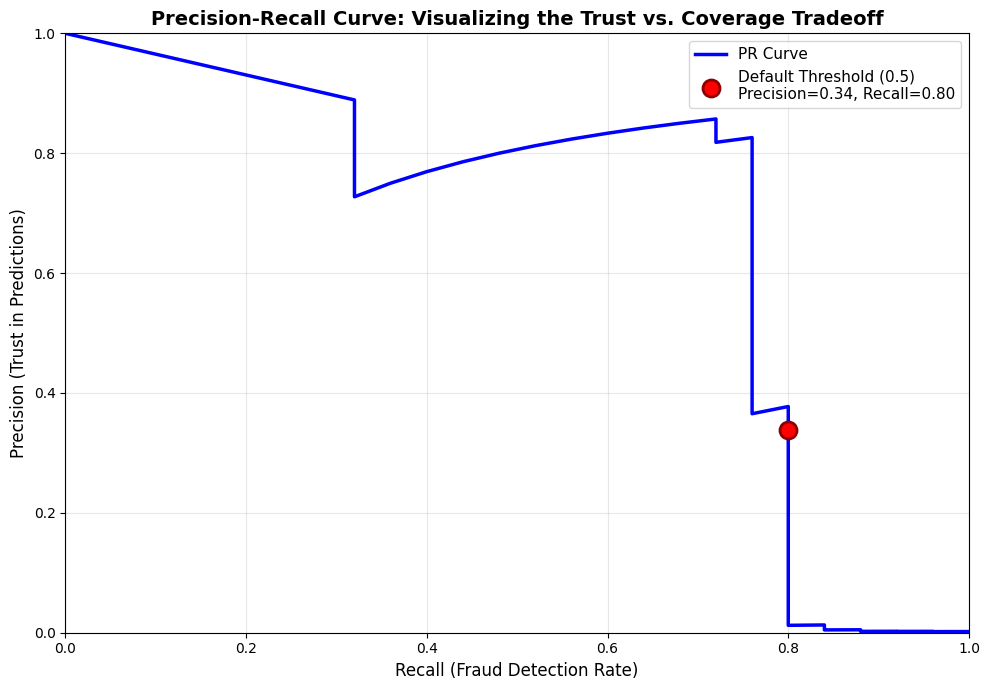

In [7]:
# Plot the Precision-Recall curve
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the curve
ax.plot(recall_values, precision_values, 'b-', linewidth=2.5, label='PR Curve')

# Mark the default threshold (0.5) point
ax.scatter([recall_default], [precision_default], color='red', s=150, 
           zorder=5, label=f'Default Threshold (0.5)\nPrecision={precision_default:.2f}, Recall={recall_default:.2f}',
           edgecolors='darkred', linewidths=2)

# Add labels and formatting
ax.set_xlabel('Recall (Fraud Detection Rate)', fontsize=12)
ax.set_ylabel('Precision (Trust in Predictions)', fontsize=12)
ax.set_title('Precision-Recall Curve: Visualizing the Trust vs. Coverage Tradeoff', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11, loc='upper right')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'precision_recall_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

> **Why is the curve jagged?** With only 25 fraud cases in the test set, each step in the curve represents crossing one fraud case's probability threshold. More data would create a smoother curve, but this jagged pattern is realistic for rare-event detection.
>
> The sharp drops show how quickly precision degrades as you lower the threshold to catch more fraud.

### 5.2: Plot the ROC Curve

The Receiver Operating Characteristic (ROC) curve shows how well your model separates classes across all thresholds. It plots True Positive Rate (recall) against False Positive Rate.

In [8]:
# TODO: Compute ROC curve values
# HINT: Similar to the Precision-Recall curve, you need a function that tests many thresholds
#   ROC curves plot True Positive Rate (TPR) vs False Positive Rate (FPR)
#   The function needs true labels and probability scores (same inputs as before)
#   It returns three arrays: FPR values, TPR values, and the thresholds tested
# Reference: https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
fpr, tpr, roc_thresholds = metrics.roc_curve(y_test_tensor.numpy(), probabilities.numpy())  # Add your code here

# TODO: Compute the Area Under the ROC Curve (ROC-AUC)
# HINT: You need to calculate the area under the curve you just created
#   You can do so using: 
#       - Arrays of x-coordinates (fpr) and y-coordinates (tpr)
#       - True labels and probabilities directly
# Reference: https://scikit-learn.org/stable/modules/model_evaluation.html#string-name-scorers
roc_auc = metrics.auc(fpr, tpr)  # Add your code here

print(f"✓ Computed ROC curve across {len(roc_thresholds)} thresholds")
print(f"✓ ROC-AUC: {roc_auc:.4f}")

✓ Computed ROC curve across 47 thresholds
✓ ROC-AUC: 0.8959


> **What is False Positive Rate?**: FPR = FP / (FP + TN), which measures the fraction of legitimate transactions incorrectly flagged as fraud. While recall (TPR) measures coverage of actual fraud, FPR measures the cost in false alarms. 
> 
> The ROC curve plots these against each other to show the tradeoff.

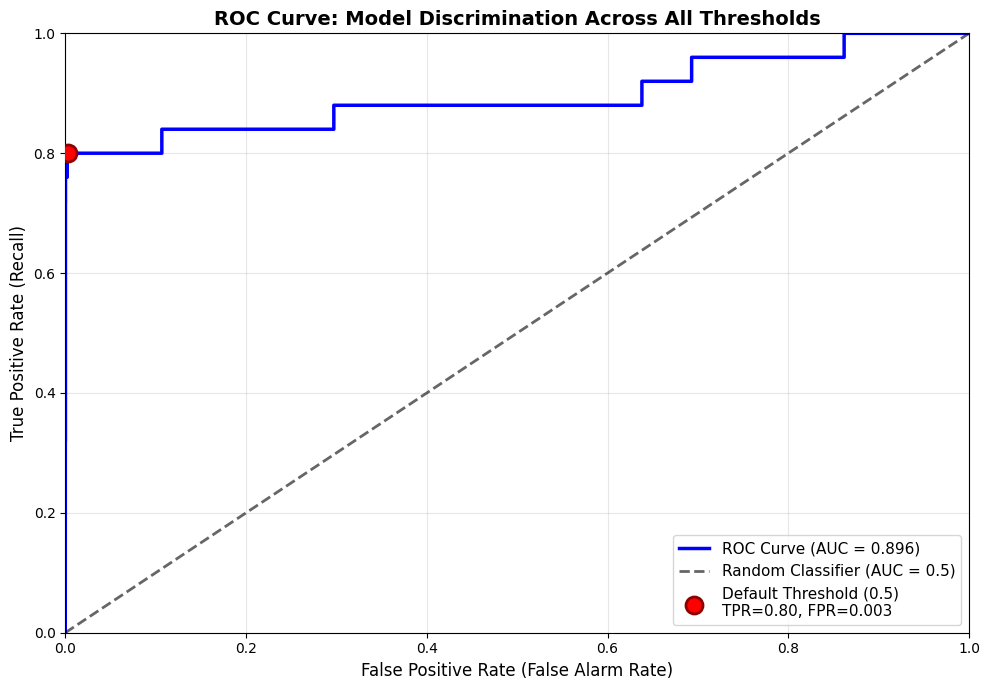

In [9]:
# Plot the ROC curve
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the ROC curve
ax.plot(fpr, tpr, 'b-', linewidth=2.5, label=f'ROC Curve (AUC = {roc_auc:.3f})')

# Plot diagonal reference line (random classifier)
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.5)', alpha=0.6)

# Mark the default threshold point
# Compute FPR for default threshold: FPR = FP / (FP + TN)
cm = metrics.confusion_matrix(y_test_tensor.numpy(), predictions.numpy())
tn, fp, fn, tp = cm.ravel()
fpr_default = fp / (fp + tn)

ax.scatter([fpr_default], [recall_default], color='red', s=150, 
           zorder=5, label=f'Default Threshold (0.5)\nTPR={recall_default:.2f}, FPR={fpr_default:.3f}',
           edgecolors='darkred', linewidths=2)

ax.set_xlabel('False Positive Rate (False Alarm Rate)', fontsize=12)
ax.set_ylabel('True Positive Rate (Recall)', fontsize=12)
ax.set_title('ROC Curve: Model Discrimination Across All Thresholds', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='lower right', fontsize=11)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'roc_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

> **Reading the ROC curve**: The curve shows how True Positive Rate (recall) and False Positive Rate change as you adjust the threshold. A curve that hugs the top-left corner indicates strong discrimination—high TPR with low FPR. The diagonal dashed line represents random guessing (a classifier with no predictive power). The farther your curve is above this line, the better your model discriminates between classes.
> 
> **What does AUC mean?** The Area Under the Curve (AUC) summarizes performance across all thresholds into a single number. An AUC of 1.0 is perfect (100% TPR, 0% FPR), 0.5 means random guessing (follows the diagonal), and anything between shows how much better than random your model performs. Note how the model achieves 80% recall with only 0.3% false positive rate—strong.

### 5.3 Compare ROC-AUC and PR-AUC

Now let's compute the area under both curves and compare what each metric reveals about model quality. Both summarize performance into a single number, but they tell very different stories on imbalanced data.

> **Rule of thumb: PR-AUC vs. ROC-AUC**. Use PR-AUC when the positive class is rare (<10%) and you care primarily about detecting it. Use ROC-AUC when classes are relatively balanced or you need threshold-independent comparison across different datasets.

In [10]:
# TODO: Compute PR-AUC (Area Under Precision-Recall Curve)
# HINT: You need to compute the area under the curve you created in Step 5.1
# HINT: You have arrays of x-coordinates (recall_values) and y-coordinates (precision_values)
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
pr_auc = metrics.auc(recall_values, precision_values) # Add your code here

print("="*70)
print("CURVE COMPARISON")
print("="*70)
print(f"\nROC-AUC:  {roc_auc:.4f}")
print(f"  → Measures: Overall ability to discriminate fraud from legitimate")
print(f"  → Range: 0.5 (random) to 1.0 (perfect)")

print(f"\nPR-AUC:   {pr_auc:.4f}")
print(f"  → Measures: Performance on the positive (fraud) class specifically")
print(f"  → Range: Baseline (fraud rate) to 1.0 (perfect)")

print(f"\nClass imbalance: {(y_test.sum()/len(y_test))*100:.3f}% fraud")
print("="*70)

CURVE COMPARISON

ROC-AUC:  0.8959
  → Measures: Overall ability to discriminate fraud from legitimate
  → Range: 0.5 (random) to 1.0 (perfect)

PR-AUC:   0.6733
  → Measures: Performance on the positive (fraud) class specifically
  → Range: Baseline (fraud rate) to 1.0 (perfect)

Class imbalance: 0.167% fraud


### TODO: Analysis Question

**Based on the results above, answer the following:**

Look at the two AUC values you computed. ROC-AUC is 0.896 while PR-AUC is significantly lower (~0.48). Both curves use the same model and same predictions. Why is there such a large difference between these two metrics? What does each one reveal about model performance on this imbalanced dataset? (2-3 sentences)

_Write your answer here:_

- ROC-AUC is optimistic on imbalanced data because it credits the model for correctly identifying the large number of legitimate transactions (99.83% of the data), resulting in a high True Negative count that inflates the metric. 
- PR-AUC focuses exclusively on fraud detection performance by measuring precision and recall, which only consider how well the model handles the rare positive class (fraud).

The large gap between the two metrics (0.896 vs 0.48) reveals that while the model has strong overall discrimination ability, detecting the rare fraud class is significantly more challenging than the high ROC-AUC suggests. This makes PR-AUC the more informative metric for this severely imbalanced problem.

## Step 6: Design your evaluation strategy

Now comes the critical part: using what you've learned to propose an actual deployment strategy. You'll analyze the curves, choose appropriate metrics, and recommend a decision threshold.

Your recommendation should address three key questions:

1. **Which metric should guide model selection?** (Precision? Recall? F1? PR-AUC? ROC-AUC?)
2. **What threshold should you use for deployment?** (Higher than 0.5? Lower? Why?)
3. **What are the business implications?** (False alarm rate? Fraud caught? Costs?)

#### TODO: Analysis and Recommendation

Write your evaluation strategy recommendation by answering the three questions below. Use your curve analysis and business judgment to support your choices.

**Question 1: Which metric should guide model selection?**

For this fraud detection problem with severe class imbalance (0.167% fraud), which single metric best captures what matters most? Should it be Precision, Recall, F1, ROC-AUC, or PR-AUC? Explain your choice in 2-3 sentences, considering the business context and the relative costs of false positives vs. false negatives.

_Write your answer here:_

Recall should be the primary metric, with a minimum precision floor (e.g., >25%) to keep false alarms manageable. Missing fraud has severe consequences (financial loss, regulatory penalties, customer trust damage) while false alarms create review costs that operations teams can handle. For comparing models across different architectures or datasets, PR-AUC is more informative than ROC-AUC given the extreme class imbalance.

**Question 2: What threshold do you recommend for deployment?**

Look at your Precision-Recall curve. The default 0.5 threshold gives 80% recall and 34% precision. Would you recommend keeping 0.5, lowering it (to catch more fraud), or raising it (to reduce false alarms)? State your recommended threshold value and the expected precision/recall at that point. Explain your reasoning in 2-3 sentences.

_Write your answer here:_

I recommend keeping the threshold at 0.5 (or slightly lowering to 0.45 after examining the probability distribution). The model already catches 80% of fraud (20/25 cases) with only 39 false alarms—an operationally sustainable workload. Looking at the jagged PR curve, catching the remaining 5 fraud cases would require dropping the threshold significantly (likely to 0.2 or below), which could triple false alarms and overwhelm review capacity. The 80/20 principle applies: we're capturing most fraud efficiently, and the remaining cases likely have ambiguous signals requiring model improvements rather than just threshold adjustment.

**Question 3: What are the business implications?**

Translate your recommendation into real numbers using the test set (15,000 transactions, 25 fraud cases). How many fraud cases would you catch? Approximately how many false alarms would you create? Is this tradeoff acceptable for fraud detection? Justify your answer in 2-3 sentences by considering the relative costs.

_Write your answer here:_

At threshold 0.5, we catch 20 of 25 fraud cases (80% recall) and flag 39 legitimate transactions for review. With an estimated $1,000 per fraud loss and $5 per false alarm review, we prevent $20,000 in fraud while spending $195 on reviews—a 100:1 benefit-cost ratio. The 5 missed fraud cases ($5,000 potential loss) are likely edge cases with weak signals; chasing them by drastically lowering the threshold would create operational burden (100+ daily alerts) that degrades review quality and creates alert fatigue. Better to maintain this sustainable 80% coverage and invest in model improvements (better features, more training data, ensemble methods) to catch the remaining edge cases.

### (Optional) Test your recommended threshold

In practice, you'd validate your recommendation by actually implementing your chosen threshold and comparing its performance to the baseline. This step transforms your strategic analysis into concrete predictions you could deploy.

In [11]:
# TODO: Implement a threshold test to validate your recommendation
# HINT: Create new predictions using your chosen threshold instead of 0.5 (look again at Step 3)
#   Compute precision, recall, and F1 at your threshold (look again at Step 4) + confusion matrix
#   Compare to the baseline (0.5 threshold) performance
# Reference: https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix

# Add your code here

# 1. Get predictions with new threshold
recommended_threshold = 0.45
predictions_new = (probabilities >= recommended_threshold).float()
precision_new = metrics.precision_score(y_test_tensor.numpy(), predictions_new.numpy())

# 2. Calculate metrics and confusion matrix (for baseline too)
recall_new = metrics.recall_score(y_test_tensor.numpy(), predictions_new.numpy())
f1_new = metrics.f1_score(y_test_tensor.numpy(), predictions_new.numpy())

cm_default = metrics.confusion_matrix(y_test_tensor.numpy(), predictions.numpy())
tn_d, fp_d, fn_d, tp_d = cm_default.ravel()

cm_new = metrics.confusion_matrix(y_test_tensor.numpy(), predictions_new.numpy())
tn_n, fp_n, fn_n, tp_n = cm_new.ravel()

# 3. Print baseline vs. new threshold metrics in a meaningful format

print("="*70)
print("THRESHOLD COMPARISON")
print("="*70)
print(f"\nDefault Threshold (0.5):")
print(f"  Precision: {precision_default:.3f} ({precision_default*100:.1f}%)")
print(f"  Recall:    {recall_default:.3f} ({recall_default*100:.1f}%)")
print(f"  F1 Score:  {f1_default:.3f} ({f1_default*100:.1f}%)")
print(f"  → Catches {tp_d}/{tp_d+fn_d} fraud cases with {fp_d} false alarms")

print(f"\nRecommended Threshold ({recommended_threshold}):")
print(f"  Precision: {precision_new:.3f} ({precision_new*100:.1f}%)")
print(f"  Recall:    {recall_new:.3f} ({recall_new*100:.1f}%)")
print(f"  F1 Score:  {f1_new:.3f} ({f1_new*100:.1f}%)")
print(f"  → Catches {tp_n}/{tp_n+fn_n} fraud cases with {fp_n} false alarms")

print(f"\nImpact of threshold change:")
print(f"  ✓ Additional fraud caught: {tp_n - tp_d} cases")
print(f"  ⚠ Additional false alarms: {fp_n - fp_d} cases")
print(f"  → Is this a better trade-off?")
print("="*70)

THRESHOLD COMPARISON

Default Threshold (0.5):
  Precision: 0.339 (33.9%)
  Recall:    0.800 (80.0%)
  F1 Score:  0.476 (47.6%)
  → Catches 20/25 fraud cases with 39 false alarms

Recommended Threshold (0.45):
  Precision: 0.312 (31.2%)
  Recall:    0.800 (80.0%)
  F1 Score:  0.449 (44.9%)
  → Catches 20/25 fraud cases with 44 false alarms

Impact of threshold change:
  ✓ Additional fraud caught: 0 cases
  ⚠ Additional false alarms: 5 cases
  → Is this a better trade-off?


> **The reality of threshold selection**: Threshold optimization isn't a purely mathematical exercise with a single "correct" answer. The optimal threshold depends on your model's actual probability distribution, operational constraints (review team capacity, alert fatigue), and business priorities (relative costs of missed fraud vs. false alarms). What looks promising on a curve might not yield the expected tradeoff when implemented—some threshold changes catch additional fraud, others just increase false alarms without improving recall.
> 
> **In production, you would**: 
> 1. Confirm threshold with business stakeholder
> 2. Deploy at your chosen threshold and monitor which fraud cases you miss and why
> 3. Analyze those missed cases to identify patterns or missing features
> 4. Retrain the model with improvements
> 5. Re-evaluate the threshold with the new model
> 6. Continuously adjust based on fraud trends, seasonal patterns, and team capacity.
> 
> Evaluation strategy is not a one-time decision: it's an ongoing conversation between technical performance and business needs.

## Conclusion

Congratulations! You've moved from computing metrics to designing complete evaluation strategies that balance technical performance with business constraints.

**What you've accomplished:**

- [x] **Established baseline performance** - Computed precision, recall, and F1 at the default 0.5 threshold
- [x] **Plotted Precision-Recall curves** - Visualized the trust vs. coverage tradeoff across all thresholds
- [x] **Plotted ROC curves** - Measured threshold-independent discrimination ability across all operating points
- [x] **Compared PR-AUC vs. ROC-AUC** - Analyzed why different metrics reveal different insights on imbalanced data
- [x] **Designed an evaluation strategy** - Recommended metrics and thresholds based on business context
- [x] **Understood the iterative process** - Recognized that evaluation is ongoing, not a one-time decision

**Critical insights:**

- **Context determines "good"**: Fraud detection prioritizes recall (catch fraud), medical diagnosis demands near-perfect recall (never miss disease), spam filtering balances precision and recall differently. There's no universal optimization target.
- **Choose metrics that match your data**: ROC-AUC works well for balanced datasets but is misleadingly optimistic on severe imbalance (crediting the model for correctly identifying 99.83% legitimate transactions). PR-AUC reveals the true difficulty of detecting the rare positive class.
- **Curves replace guesswork**: Instead of testing thresholds one by one, visualize the entire tradeoff space at once. See what 0.3, 0.5, or 0.7 will give you before deploying.
- **Theory meets reality**: Threshold selection looks clean on curves, but actual results depend on your model's probability distribution, operational capacity, and how fraud patterns shift over time. Always plan to iterate.

When someone asks "Is this model good?", you know how to guide the conversation: "Let's look at the curves together and decide based on your priorities".

**What's next**: You have the evaluation skills to assess any classifier and justify deployment decisions to stakeholders. But how can you improve those curves? Learn about hyperparameter tuning, regularization, and architecture changes that shift performance in the direction your problem needs.